# Data preparation

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [127]:
df = pd.read_json('data_complete.json')
df = df[['description', 'sector']]

# replace empty strings with nan values
df = df.replace('', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9856 entries, 0 to 9855
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  9856 non-null   object
 1   sector       9833 non-null   object
dtypes: object(2)
memory usage: 154.1+ KB


In [128]:
# drop nan values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9833 entries, 0 to 9855
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  9833 non-null   object
 1   sector       9833 non-null   object
dtypes: object(2)
memory usage: 230.5+ KB


In [129]:
df.sector.value_counts()

Financial Services        2503
Healthcare                1452
Industrials               1307
Technology                1139
Consumer Cyclical         1023
Basic Materials            594
Real Estate                489
Consumer Defensive         410
Communication Services     403
Energy                     338
Utilities                  164
Industrial Goods             4
Services                     3
Financial                    3
Consumer Goods               1
Name: sector, dtype: int64

In [130]:
# consolidate data
df = df.replace('Services', 'Financial Services')
df = df.replace('Industrial Goods', 'Industrials')
df = df.replace('Financial', 'Financial Services')
df = df.replace('Consumer Goods', 'Consumer Cyclical')
df = df.replace(to_replace=['Energy', 'Utilities'], value='Energy & Utility')

In [131]:
df.sector.value_counts()

Financial Services        2509
Healthcare                1452
Industrials               1311
Technology                1139
Consumer Cyclical         1024
Basic Materials            594
Energy & Utility           502
Real Estate                489
Consumer Defensive         410
Communication Services     403
Name: sector, dtype: int64

In [132]:
df[df.sector == 'Financial Services']

,description,sector
0,Adara Acquisition Corp. does not have signific...,Financial Services
2,"Ashford, Inc is an asset management firm. The ...",Financial Services
5,"Aberdeen Emerging Markets Equity Income Fund, ...",Financial Services
7,"Aberdeen Australia Equity Fund, Inc. is a clos...",Financial Services
11,Allspring Multi-Sector Income Fund is a closed...,Financial Services
...,...,...
9840,NÜRNBERGER Beteiligungs-AG operates as an insu...,Financial Services
9842,"ÖKOWORLD AG, together with its subsidiaries, p...",Financial Services
9846,Scherzer & Co. AG is a publicly owned investme...,Financial Services
9847,The NAGA Group AG develops technologies for th...,Financial Services


In [134]:
df.head()

,description,sector,label
0,Adara Acquisition Corp. does not have signific...,Financial Services,1
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,0
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,1
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,0
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,0


In [135]:
df_fs = df
df_fs['label'] = (df_fs.sector == 'Financial Services').astype(int)
df_fs.sector = pd.Categorical(df.sector)
df_fs['code'] = df.sector.cat.codes
df_fs.head()

,description,sector,label,code
0,Adara Acquisition Corp. does not have signific...,Financial Services,1,5
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,0,6
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,1,5
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,0,1
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,0,3


## Neural network

In [136]:
grouped_df_fs = df_fs.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df_fs]

train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [137]:
for dataset in [train, val, test]:
    print(dataset.sector.value_counts(), '\n')

Financial Services        2007
Healthcare                1161
Industrials               1048
Technology                 911
Consumer Cyclical          819
Basic Materials            475
Energy & Utility           401
Real Estate                391
Consumer Defensive         328
Communication Services     322
Name: sector, dtype: int64 

Financial Services        251
Healthcare                146
Industrials               132
Technology                114
Consumer Cyclical         103
Basic Materials            60
Energy & Utility           51
Real Estate                49
Communication Services     41
Consumer Defensive         41
Name: sector, dtype: int64 

Financial Services        251
Healthcare                145
Industrials               131
Technology                114
Consumer Cyclical         102
Basic Materials            59
Energy & Utility           50
Real Estate                49
Consumer Defensive         41
Communication Services     40
Name: sector, dtype: int64 



In [138]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    df = dataframe.copy()
    label = df.pop('label')
    df = dataframe["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, label))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    # ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [139]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [140]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [141]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(64, 50), dtype=float32, numpy=
array([[ 0.44474393, -0.14037693,  0.20955482, ..., -0.33867264,
         0.08122318,  0.04481157],
       [ 0.7173351 ,  0.1412179 ,  0.35123813, ..., -0.34808332,
        -0.21860662,  0.6960719 ],
       [ 0.6881574 , -0.0247677 ,  0.76582056, ..., -0.38144028,
         0.09016543,  0.71932334],
       ...,
       [ 0.33776015,  0.12157122,  0.21610978, ..., -0.0009753 ,
        -0.29281253,  0.3601746 ],
       [ 0.59067774, -0.47910532,  0.17950474, ..., -0.2811049 ,
        -0.3612782 ,  0.54313076],
       [ 0.8267665 , -0.09284584,  0.01283348, ..., -0.453855  ,
        -0.41714674,  0.20929831]], dtype=float32)>

In [142]:
model = tf.keras.Sequential([
    hub_layer,
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='softmax')
])

In [143]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(patience=2, verbose=1, restore_best_weights=True)

In [144]:
model.evaluate(train_data)

123/123 [==============================] - 0s 2ms/step - loss: 3.3148 - accuracy: 0.0000e+00


[3.3147873878479004, 0.0]

In [145]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=10,
                    callbacks=[es])

Epoch 1/10
123/123 [==============================] - 51s 414ms/step - loss: 1.4530 - accuracy: 0.6083 - val_loss: 0.7293 - val_accuracy: 0.8229
Epoch 2/10
123/123 [==============================] - 52s 421ms/step - loss: 0.4177 - accuracy: 0.9705 - val_loss: 0.4406 - val_accuracy: 0.9150
Epoch 3/10
123/123 [==============================] - 51s 411ms/step - loss: 0.2424 - accuracy: 0.9875 - val_loss: 0.3737 - val_accuracy: 0.9089
Epoch 4/10
123/123 [==============================] - 51s 418ms/step - loss: 0.1619 - accuracy: 0.9914 - val_loss: 0.3240 - val_accuracy: 0.9150
Epoch 5/10
123/123 [==============================] - 51s 413ms/step - loss: 0.1170 - accuracy: 0.9947 - val_loss: 0.3105 - val_accuracy: 0.9140
Epoch 6/10
123/123 [==============================] - 51s 413ms/step - loss: 0.0905 - accuracy: 0.9972 - val_loss: 0.2709 - val_accuracy: 0.9231
Epoch 7/10
123/123 [==============================] - 51s 416ms/step - loss: 0.0736 - accuracy: 0.9987 - val_loss: 0.2816 - val_ac

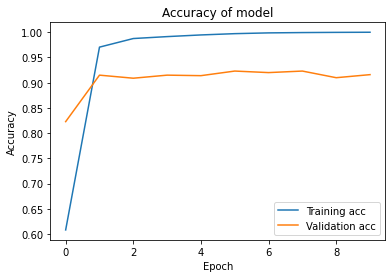

In [146]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

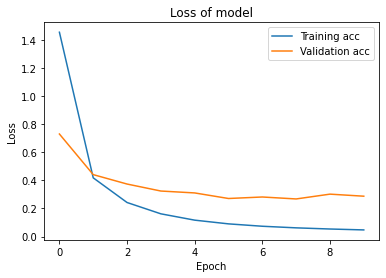

In [147]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [148]:
model.evaluate(test_data)

16/16 [==============================] - 1s 51ms/step - loss: 0.0811 - accuracy: 0.9908


[0.08112736791372299, 0.9908350110054016]